In [1]:
import pandas as pd
import numpy as np
from scipy.stats import qmc
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
sheets = pd.ExcelFile('hist_data_updated.xlsm').sheet_names
stocks = pd.DataFrame()
for sheet in sheets:
    temp = pd.read_excel('hist_data_updated.xlsm', sheet_name = sheet)
    if sheet != 'SofrCurve':
        stocks['Date'] = temp['Date']
        stocks[sheet] = temp['Adj Close']
    else:
        swap = temp

stocks.set_index('Date', inplace = True)

In [3]:
def plot(change, var, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.title(title)
    plt.hist(change, density = True, bins = 50, alpha = 0.5)
    plt.axvline(x = -var, color = 'r')

    mu, std = norm.fit(change)
    xmin, xmax = change.min(), change.max()
    x = np.linspace(xmin, xmax, 10000)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)

    ax.xaxis.set_major_formatter('${x:1,.0f}');

# Initial Value

In [4]:
VaR_percentile = 5

### Stock

In [5]:
# initial value of holdings
stocks_holdings_value = np.array([1e6] * 4)

# compute returns
for col in stocks.columns:
    stocks[f'{col}_ret'] = stocks[col].pct_change()

stocks_price = stocks[[col for col in stocks.columns if 'ret' not in col]].iloc[-1].to_numpy()

share_holdings = stocks_holdings_value / stocks_price # shares owned

### Swap

In [6]:
swap_notional = 100e6
fixed_leg_ir = 0.042

# formatting df
sofr = swap.T.iloc[2:]
sofr.columns = swap['T'].unique()

# filter for 1-10Y rates
sofr = sofr[[i for i in range(1, 11)]]

DF = sofr.copy()

# compute disocunt factors
for i in range(len(DF.columns)):
    DF[DF.columns[i]] = np.exp(- DF[DF.columns[i]].astype(float) * (i + 1))


def PV_payer_swap(discount_factors):
    # payer swap PV = notional + (- notional * tenor DF - discounted CF of fixed leg)
    float_leg =  (1 - discount_factors[9])
    fix_leg = fixed_leg_ir * discount_factors.sum()
    payer_swap_PV  = swap_notional * (float_leg - fix_leg)

    return payer_swap_PV

# compute current value of swap
today_DF = DF.iloc[-1, ].to_numpy()
payer_swap_today = PV_payer_swap(today_DF)

### Portfolio

In [7]:
port_value = payer_swap_today + stocks_holdings_value.sum()

print(f'Stock Value: ${round(stocks_holdings_value.sum(), 2):,}')
print(f'Swap Value: ${round(payer_swap_today, 2):,}')
print(f'Portfolio Value: ${round(port_value, 2):,}')

Stock Value: $4,000,000.0
Swap Value: $2,442,902.0
Portfolio Value: $6,442,902.0


# Parametric VaR

### Stock

In [8]:
# stock returns
stocks_rets = stocks[[col for col in stocks.columns if 'ret' in col]].dropna()

# current stock price
curr_stocks_price = stocks[[col for col in stocks.columns if 'ret' not in col]].iloc[-1].to_numpy()

# stock returns statistics
stocks_mean = stocks_rets.mean(axis = 0).to_numpy()
stocks_std = stocks_rets.std(axis = 0).to_numpy()
stocks_cov = stocks[[col for col in stocks.columns if 'ret' in col]].iloc[1:, ].cov().to_numpy()

# parametric stock statistics
Para_stock_mean = (stocks_mean * stocks_holdings_value).sum()
Para_stock_std = np.sqrt((stocks_holdings_value @ stocks_cov) @ stocks_holdings_value.T)

### Swap


In [9]:
bp_change = 0.0001

n_tenors = len(sofr.columns)
payer_change = np.zeros(n_tenors)

sofr_delta = sofr.diff().dropna()

# filter for rates on that day
sofr_today = sofr.iloc[-1, ].to_numpy()

for tenor in range(n_tenors):

    # add 1bp to the rate for that tenor
    pv01_sofr = np.zeros(len(sofr_today))

    for j in range(n_tenors):
        if j == tenor:
            pv01_sofr[j] = sofr_today[j] + bp_change
        else:
            pv01_sofr[j] = sofr_today[j]

    new_DF = np.zeros(len(pv01_sofr))

    # compute new discount factors
    for i in range(len(pv01_sofr)):
        new_DF[i] = np.exp(- pv01_sofr[i] * (i + 1))

    # compute PV01 change in swap value
    payer_change[tenor] = PV_payer_swap(new_DF) - payer_swap_today

# convert bp to rate %
pv01 = payer_change / bp_change

# mean change in rates
sofr_mean = sofr_delta.mean(axis = 0).to_numpy()

# std change in rates 
sofr_std = sofr_delta.std(axis = 0).to_numpy()

# covariance matrixs of rates
sofr_cov = (sofr_delta).cov(numeric_only = False).to_numpy()

# Parametric swap statistics
Para_swap_mean = (pv01 * sofr_mean).sum()
Para_swap_std = np.sqrt((pv01 @ sofr_cov) @ pv01.T)

In [10]:
# z value
z = norm.ppf(VaR_percentile / 100)

# Parametric VaR for individual assets
Para_stock_VaR = abs(Para_stock_mean + z * Para_stock_std)
Para_swap_VaR = abs(Para_swap_mean + z * Para_swap_std)

print(f'Parametric Stock 95% VaR: ${round(Para_stock_VaR, 2):,}')
print(f'Parametric Swap 95% VaR: ${round(Para_swap_VaR, 2):,}')

Parametric Stock 95% VaR: $87,349.27
Parametric Swap 95% VaR: $927,276.45


### Portfolio

In [11]:
port = np.append(pv01, stocks_holdings_value)

portfolio_risk_changes = pd.concat([sofr_delta, stocks_rets], axis = 1)
portfolio_risk_changes_cov = portfolio_risk_changes.cov(numeric_only = False)

portfolio_risk_changes_mean = portfolio_risk_changes.mean().to_numpy()
portfolio_risk_changes_std = portfolio_risk_changes.std().to_numpy()

Para_port_mean = port @ portfolio_risk_changes_mean
Para_port_std = np.sqrt(port @ portfolio_risk_changes_cov @ port.T)

Para_port_VaR = abs(Para_port_mean + z * Para_port_std)

print(f'Parametric Portfolio 95% VaR: ${round(Para_port_VaR, 2):,}')

Parametric Portfolio 95% VaR: $927,138.23


# Monte Carlo

In [12]:
def simulate(dimension, power):
    simulation = qmc.Sobol(d = dimension, scramble = False)
    simulation = simulation.random_base2(m = power)
    simulation = np.delete(simulation, 0, axis = 0)
    print(f'{dimension} X {2 ** power:,} simulations generated')

    return simulation

# Simulate risk factor changes
portfolio_risk_changes_simulation = simulate(len(stocks_holdings_value) + len(sofr.columns), 21)

# compute correlation matrix and cholesky decomposition
portfolio_corr_matrix = portfolio_risk_changes.corr(numeric_only = False).to_numpy()
portfolio_cholesky = np.linalg.cholesky(portfolio_corr_matrix)

# norm inverse to get normal distribution
portfolio_simulated_risk_changes = norm.ppf(portfolio_risk_changes_simulation, loc = 0, scale = 1)

# compute correlated samples
portfolio_simulated_risk_changes = (portfolio_cholesky @ portfolio_simulated_risk_changes.T).T

# unstandardize correlated samples to distribution of portfolio
portfolio_simulated_risk_changes = portfolio_simulated_risk_changes * portfolio_risk_changes_std + portfolio_risk_changes_mean

# stock simulated returns
stock_simulated_returns = portfolio_simulated_risk_changes[:, 10:]

# SOFR simulated rate changes
sofr_simulated = portfolio_simulated_risk_changes[:, :10]

14 X 2,097,152 simulations generated


### Swap

#### Full Revaluation

Monte Carlo Full Revaluation Payer SOFR Swap 95% VaR: $932,795.79


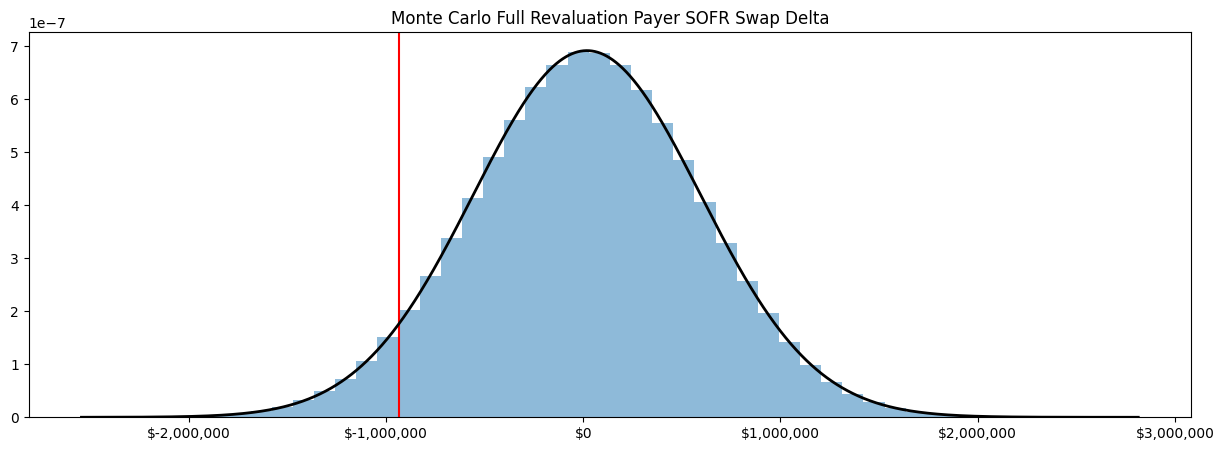

In [13]:
# today's sofr
sofr_today = sofr.iloc[-1, ].to_numpy()

# apply changes in risk factors to today's sofr
new_DF = (sofr_today + sofr_simulated).T

# compute discount factor for each time period
for i in range(len(new_DF)):
    new_DF[i] = np.exp(- new_DF[i].astype(float) * (i + 1))

n = len(sofr_simulated)
MC_full_reval_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    MC_full_reval_payer[i] = PV_payer_swap(new_DF.T[i])

# calculate change in swap value
MC_full_reval_payer = MC_full_reval_payer - payer_swap_today

MC_full_reval_payer_VaR = abs(np.percentile(MC_full_reval_payer, VaR_percentile))

print(f'Monte Carlo Full Revaluation Payer SOFR Swap 95% VaR: ${round(MC_full_reval_payer_VaR, 2):,}')
plot(MC_full_reval_payer, MC_full_reval_payer_VaR, 'Monte Carlo Full Revaluation Payer SOFR Swap Delta')

#### Risk-Based

Monte Carlo Risk-Based Payer SOFR Swap 95% VaR: $927,431.49


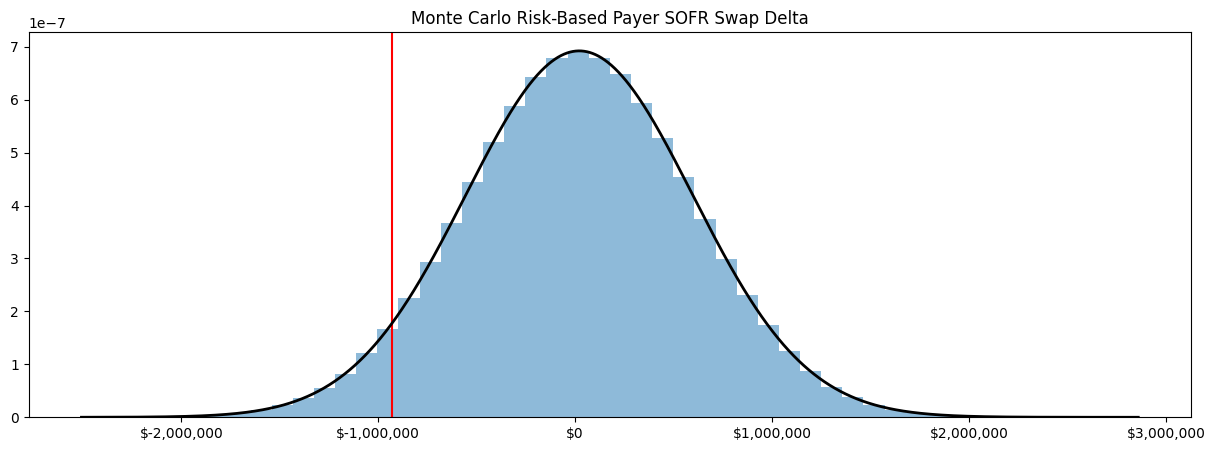

In [14]:
# compute payer swap value for each risk factor using PV01
MC_risk_based_payer = (pv01 * sofr_simulated).sum(axis = 1)

# 5th percentile for VaR
MC_risk_based_payer_VaR = abs(np.percentile(MC_risk_based_payer, VaR_percentile))

print(f'Monte Carlo Risk-Based Payer SOFR Swap 95% VaR: ${round(MC_risk_based_payer_VaR, 2):,}')
plot(MC_risk_based_payer, MC_risk_based_payer_VaR, 'Monte Carlo Risk-Based Payer SOFR Swap Delta')

### Stock

#### Full Revaluation

Monte Carlo Full Revaluation Stock 95% VaR: $87,313.48


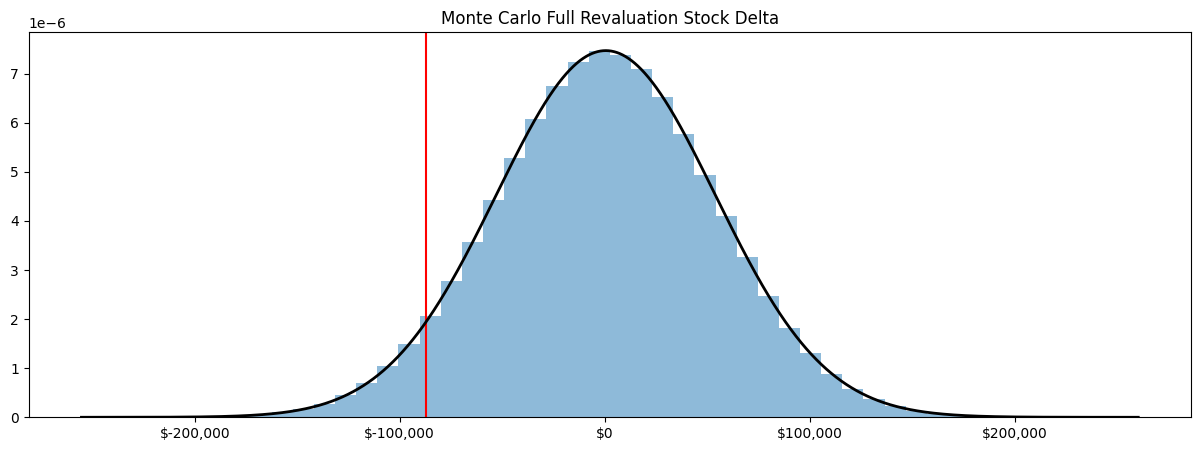

In [15]:
# apply risk factor to today's prices to get new stock prices
MC_full_reval_prices = curr_stocks_price * (1 + stock_simulated_returns)

# multiply shares with stock price to get new stock portfolio value
MC_full_reval_stock_port = share_holdings * MC_full_reval_prices

# subtract new stock portfolio value from current value 
MC_full_reval_stock_port_change = (MC_full_reval_stock_port - stocks_holdings_value).sum(axis = 1)

# 5% VaR for stock
MC_full_reval_VaR = abs(np.percentile(MC_full_reval_stock_port_change, VaR_percentile))

print(f'Monte Carlo Full Revaluation Stock 95% VaR: ${round(MC_full_reval_VaR, 2):,}')

plot(MC_full_reval_stock_port_change, MC_full_reval_VaR,'Monte Carlo Full Revaluation Stock Delta' )

#### Risk-Based

Monte Carlo Risk-Based Stock 95% VaR: $87,313.48


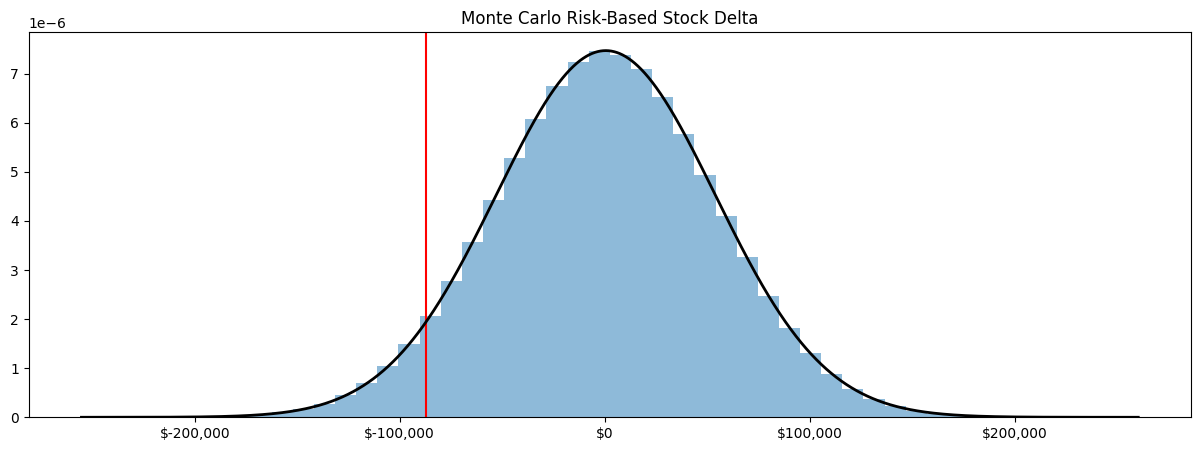

In [16]:
# calculate change as a result of risk factor to the portfolio value
MC_risk_based_stock_port_change = stocks_holdings_value * stock_simulated_returns 
MC_risk_based_stock_port_change = MC_risk_based_stock_port_change.sum(axis = 1)

# 5% VaR for stock
MC_risk_based_VaR = abs(np.percentile(MC_risk_based_stock_port_change, VaR_percentile))

print(f'Monte Carlo Risk-Based Stock 95% VaR: ${round(MC_risk_based_VaR, 2):,}')

plot(MC_risk_based_stock_port_change, MC_risk_based_VaR, 'Monte Carlo Risk-Based Stock Delta')

### Overall

#### Full Revaluation

Monte Carlo Full Revaluation Portfolio 95% VaR: $932,670.01


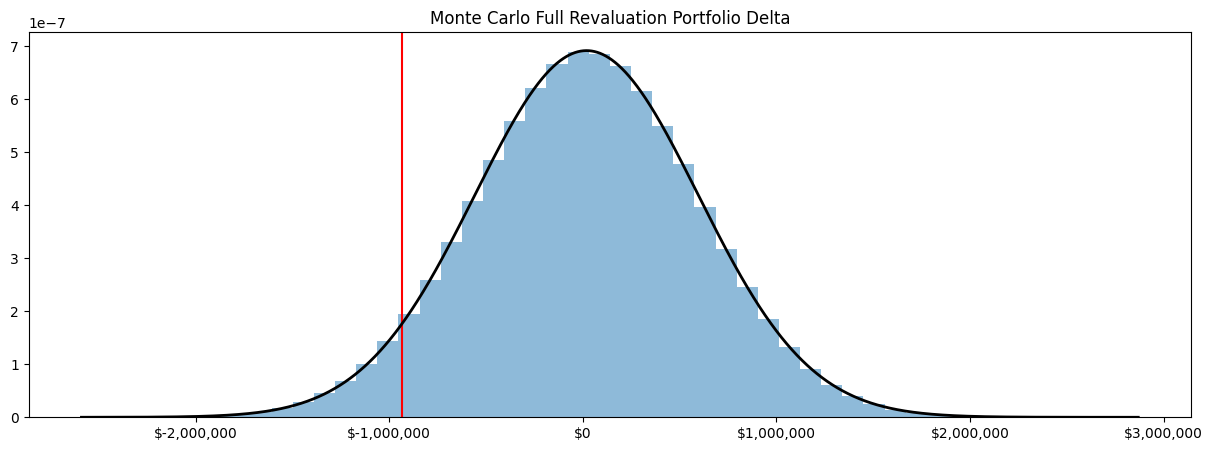

In [17]:
# sum portfolio changes due to swap and stock
MC_full_reval_portfolio_change = MC_full_reval_payer + MC_full_reval_stock_port_change

# 5th percentile for VaR
MC_full_reval_portfolio_VaR = abs(np.percentile(MC_full_reval_portfolio_change, VaR_percentile))
print(f'Monte Carlo Full Revaluation Portfolio 95% VaR: ${round(MC_full_reval_portfolio_VaR, 2):,}')

plot(MC_full_reval_portfolio_change, MC_full_reval_portfolio_VaR, 'Monte Carlo Full Revaluation Portfolio Delta')

#### Risk-Based

Monte Carlo Risk-Based Portfolio 95% VaR: $927,341.19


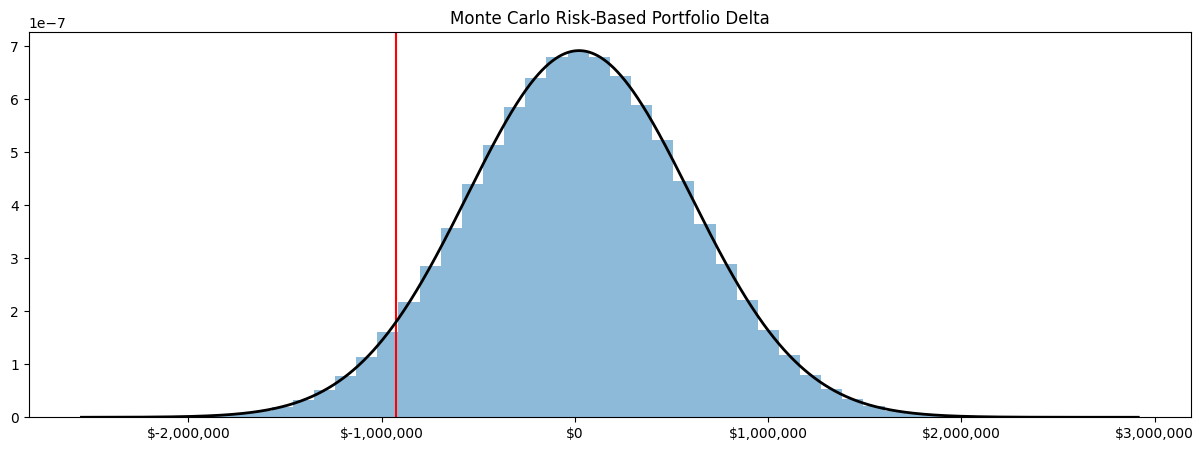

In [18]:
# sum portfolio changes due to swap and stock
MC_risk_based_portfolio_change = MC_risk_based_payer + MC_risk_based_stock_port_change

# 5th percentile for VaR
MC_risk_based_portfolio_VaR = abs(np.percentile(MC_risk_based_portfolio_change, VaR_percentile))
print(f'Monte Carlo Risk-Based Portfolio 95% VaR: ${round(MC_risk_based_portfolio_VaR, 2):,}')

plot(MC_risk_based_portfolio_change, MC_risk_based_portfolio_VaR, 'Monte Carlo Risk-Based Portfolio Delta')

# Historical

### Swap

#### Full Revaluation

Historical Full Revaluation Payer SOFR Swap 95% VaR: $960,793.15


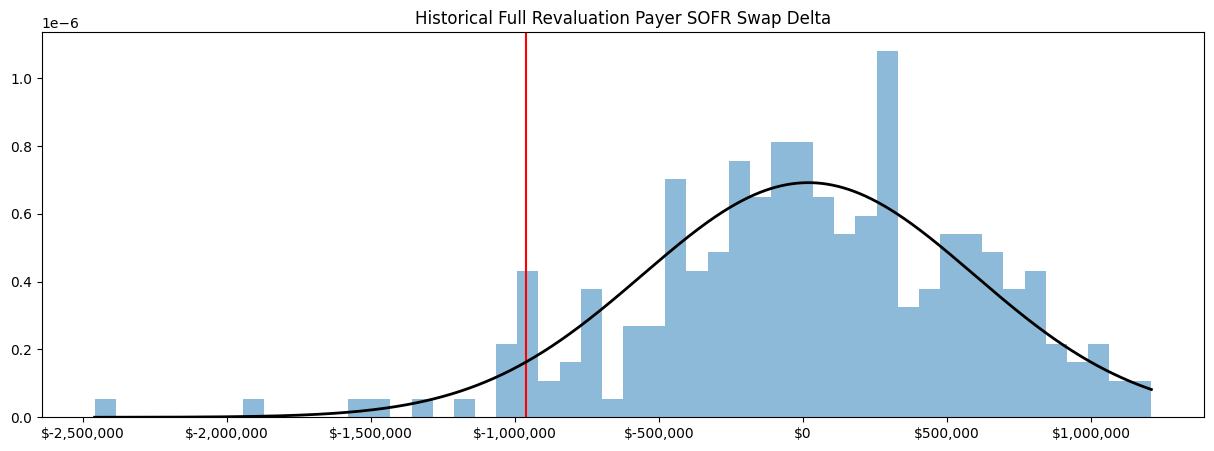

In [19]:
# sofr rate today
sofr_today = sofr.iloc[-1, ].to_numpy()

# apply historical rate changes to today's rates
new_DF = pd.DataFrame(sofr_today + sofr_delta.to_numpy())

# compute new discount factors for each period
for i in range(len(new_DF.columns)):
    new_DF[new_DF.columns[i]] = np.exp(- new_DF[new_DF.columns[i]].astype(float) * (i + 1))

new_DF = new_DF.to_numpy()

n = len(sofr_delta)
HS_full_reval_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    HS_full_reval_payer[i] = PV_payer_swap(new_DF[i])

# calculate change in value of swap
HS_full_reval_payer = HS_full_reval_payer - payer_swap_today
HS_full_reval_payer_VaR = abs(np.percentile(HS_full_reval_payer, VaR_percentile))

print(f'Historical Full Revaluation Payer SOFR Swap 95% VaR: ${round(HS_full_reval_payer_VaR, 2):,}')
plot(HS_full_reval_payer, HS_full_reval_payer_VaR, 'Historical Full Revaluation Payer SOFR Swap Delta')

#### Risk-Based

Historical Risk-Based Payer SOFR Swap 95% VaR: $955,214.31


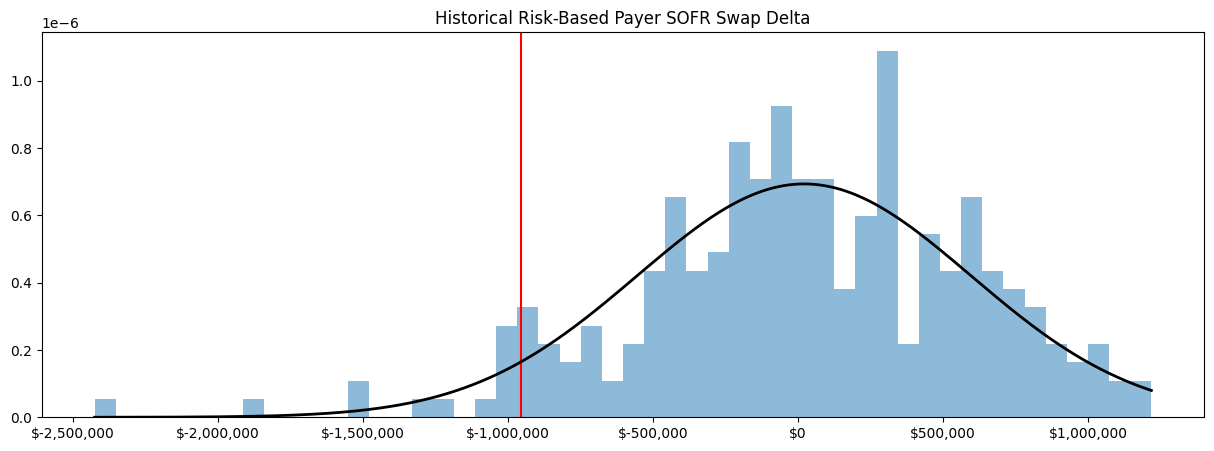

In [20]:
# compute payer swap value for each risk factor using PV01
HS_risk_based_payer = (pv01 * sofr_delta.to_numpy()).sum(axis = 1).astype(float)

# 5th percentile for VaR
HS_risk_based_payer_VaR = abs(np.percentile(HS_risk_based_payer, VaR_percentile))

print(f'Historical Risk-Based Payer SOFR Swap 95% VaR: ${round(HS_risk_based_payer_VaR, 2):,}')
plot(HS_risk_based_payer, HS_risk_based_payer_VaR, 'Historical Risk-Based Payer SOFR Swap Delta')

### Stock

#### Full Revaluation

Historical Full Revaluation Stock 95% VaR: $82,922.77


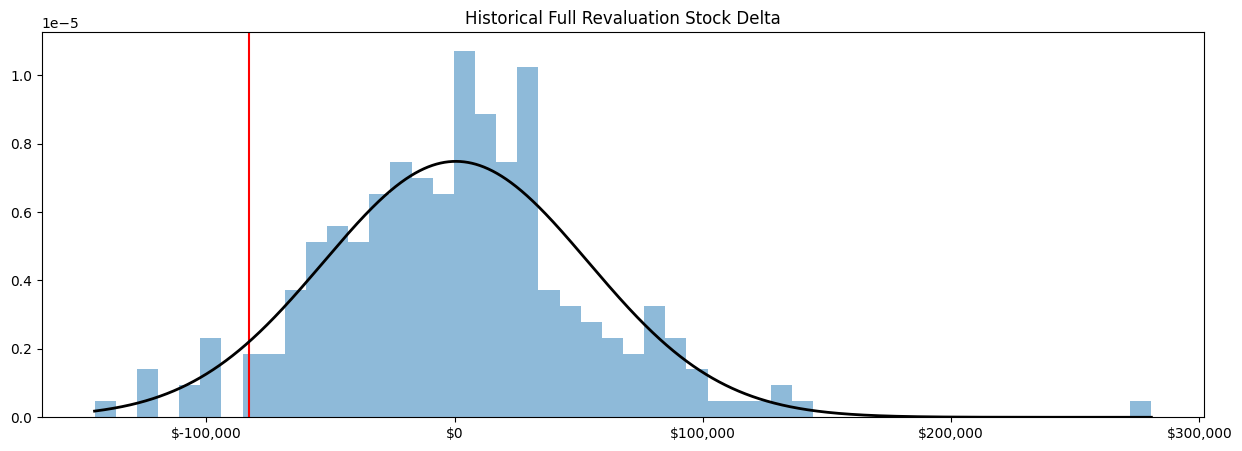

In [21]:
# apply risk factor to today's prices to get new stock prices
HS_full_reval_prices = stocks_price * (1 + stocks_rets)

# multiply shares with stock price to get new stock portfolio value
HS_full_reval_stock_port = share_holdings * HS_full_reval_prices

# subtract new stock portfolio value from current value 
HS_full_reval_stock_port_change = (HS_full_reval_stock_port - stocks_holdings_value).sum(axis = 1) 
HS_full_reval_VaR = abs(np.percentile(HS_full_reval_stock_port_change, VaR_percentile))

print(f'Historical Full Revaluation Stock 95% VaR: ${round(HS_full_reval_VaR, 2):,}')
plot(HS_full_reval_stock_port_change, HS_full_reval_VaR, 'Historical Full Revaluation Stock Delta')

#### Risk-Based

Historical Risk-Based Stock 95% VaR: $82,922.77


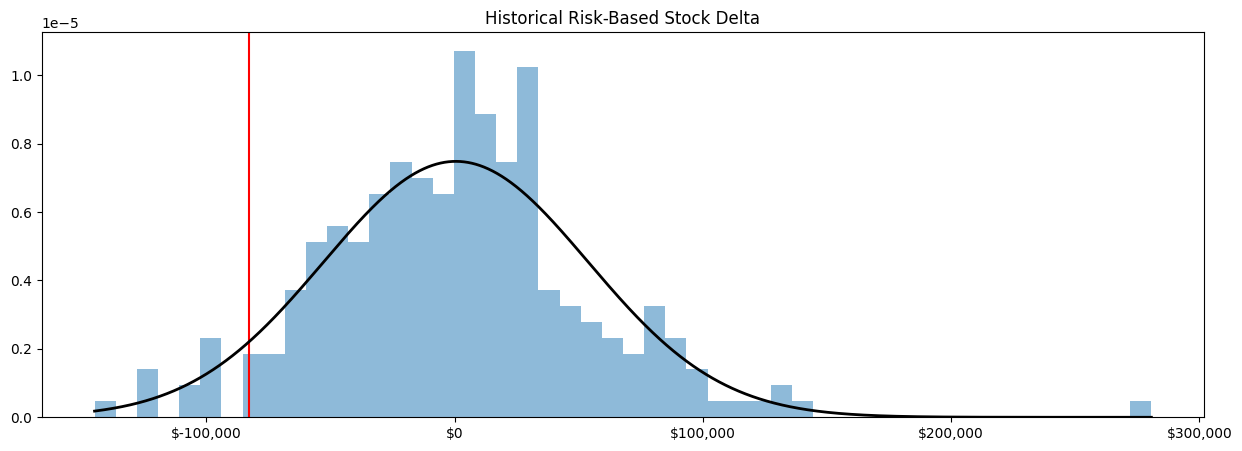

In [22]:
# immediately multiply change in risk to holdings
HS_risk_based_stock_port_change = stocks_holdings_value * stocks_rets

# sum change
HS_risk_based_stock_port_change = HS_risk_based_stock_port_change.sum(axis = 1)

# 5th percentile for VaR
HS_risk_based_VaR = abs(np.percentile(HS_risk_based_stock_port_change, VaR_percentile))

print(f'Historical Risk-Based Stock 95% VaR: ${round(HS_full_reval_VaR, 2):,}')
plot(HS_risk_based_stock_port_change, HS_risk_based_VaR, 'Historical Risk-Based Stock Delta')

### Overall

Historical Full Revaluation Portfolio 95% VaR: $984,781.39


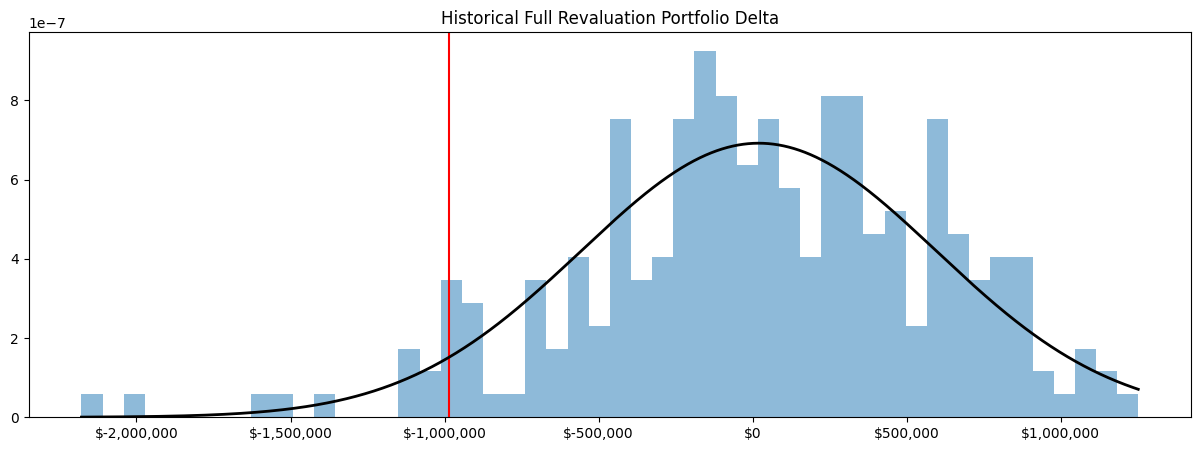

In [23]:
# sum portfolio changes due to swap and stock
HS_full_reval_portfolio_change = HS_full_reval_payer + HS_full_reval_stock_port_change

# 5th percentile for VaR
HS_full_reval_portfolio_VaR = abs(np.percentile(HS_full_reval_portfolio_change, VaR_percentile))

print(f'Historical Full Revaluation Portfolio 95% VaR: ${round(HS_full_reval_portfolio_VaR, 2):,}')
plot(HS_full_reval_portfolio_change, HS_full_reval_portfolio_VaR, 'Historical Full Revaluation Portfolio Delta')

#### Risk-Based

Historical Risk-Based Portfolio 95% VaR: $978,693.27


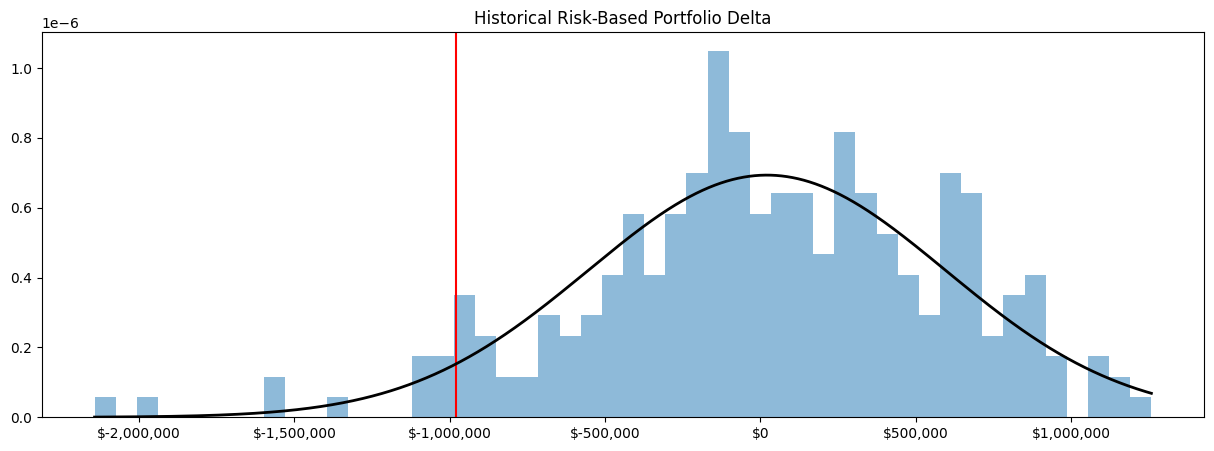

In [24]:
# sum portfolio changes due to swap and stock
HS_risk_based_portfolio_change = HS_risk_based_payer + HS_risk_based_stock_port_change

# 5th percentile for VaR
HS_risk_based_portfolio_VaR = abs(np.percentile(HS_risk_based_portfolio_change, VaR_percentile))

print(f'Historical Risk-Based Portfolio 95% VaR: ${round(HS_risk_based_portfolio_VaR, 2):,}')
plot(HS_risk_based_portfolio_change, HS_risk_based_portfolio_VaR, 'Historical Risk-Based Portfolio Delta')

In [25]:
print(f'parametric ${round(Para_port_VaR, 2):,}')
print(f'MC full reval ${round(MC_full_reval_portfolio_VaR, 2):,}')
print(f'MC risk based ${round(MC_risk_based_portfolio_VaR, 2):,}')
print(f'hist full reval ${round(HS_full_reval_portfolio_VaR, 2):,}')
print(f'hist risk based ${round(HS_risk_based_portfolio_VaR, 2):,}')

parametric $927,138.23
MC full reval $932,670.01
MC risk based $927,341.19
hist full reval $984,781.39
hist risk based $978,693.27
